In [31]:
import os 
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
import time
import catboost
from src.preprocessing import *
from src.master import*
from src.feature_engineering import *
#PATH
Path_Aircraft = 'data/1. AC characteristics/ACchar.xlsx'
Path_correspondance_Aircraft_Airport = 'Correspondance.pkl'
path_glossary = 'data/Glossary.xlsx'
Path_AirportData = 'data/0. Airport data/Airport_Data.csv'
Path_WeatherData = 'data/2. Weather data/weather_data_prep.csv'

In [32]:
# X = master_preprocessing_X(Path_AirportData, Path_WeatherData, Path_Aircraft, Path_correspondance_Aircraft_Airport)
# y = create_target(X)
#X = pd.read_pickle('MergedNotCleanedDesignMatrix.pkl')
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
# X.to_pickle('X.pkl')
# y.to_pickle('y.pkl')

In [33]:
col_numerical = ['MTOW','Wingspan, ft', 'Length, ft', 'Approach Speed\n(Vref)','AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN','WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT08']
col_category = ['carrier', 'acType','runway', 'stand','ATCT Weight Class','Wake Category','AAC', 'ADG', 'TDG','SnowProxi']
col_to_drop=[ 'flight','sto', 'aldt', 'eibt','aibt',
       'cibt', 'chocks_on', 'Manufacturer','Physical Class (Engine)',
       '# Engines',
       'Wingtip Configuration',
       'Tail Height, ft\n(@ OEW)', 'Wheelbase, ft',
       'Cockpit to Main Gear (CMG)', 'MGW\n(Outer to Outer)',
       'Max Ramp\nMax Taxi', 'Main Gear Config', 'ICAO Code', 'Years Manufactured', 'Note',
       'Parking Area (WS x Length), sf','Model']

In [ ]:
X_clean = drop_imput_scaled_dummies(X,col_numerical,col_to_drop,col_category)

#for catboost
X_clean[col_category] = X_clean[col_category].apply(lambda x: x.astype('str'))
X_clean[col_numerical] = X_clean[col_numerical].apply(lambda x: x.astype('float'))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_clean,y,1000)

In [ ]:
time_start = time.clock()
pred = RF_modeling(X_train,X_test,y_train)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

In [ ]:
test_size = 1000
X_train, X_test = X_clean[0:len(X_clean)-test_size], X_clean[len(X_clean)-test_size:len(X_clean)]
y_train, y_test = y[0:len(y)-test_size], y[len(y)-test_size:len(y)]

In [ ]:
X.replace({'tbd': np.nan}, inplace=True)
for i in col_numerical:
    X[i].fillna(X[i].median(),inplace=True)


In [ ]:
# droping useless column
X = X.drop(col_to_drop, axis=1)

# Scaling numerical values 
if len(col_numerical)>0:
    scaler = MinMaxScaler()
    X[col_numerical] = scaler.fit_transform(X[col_numerical])
    
# dummies transformation
X = pd.get_dummies(X, columns=col_category,drop_first=True)


In [ ]:
## train/test split 
test_size = 1000
X_train, X_test = X[0:len(X)-test_size], X[len(X)-test_size:len(X)]
y_train, y_test = y[0:len(y)-test_size], y[len(y)-test_size:len(y)]


In [ ]:
## Model
time_start = time.clock()
rf = RandomForestClassifier(n_estimators= 400, min_samples_split= 3, min_samples_leaf= 2, max_features= 'auto',max_depth= 50,bootstrap=True ,random_state=10)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

In [ ]:
TEST1 = pred/60
TEST2 = [x/60 for x in y_test[0].tolist()]
np.sqrt(sk.metrics.mean_squared_error(TEST1,TEST2))

In [ ]:
np.mean(TEST2)

In [ ]:
def drop_scaled_dummies(X):
    col_numerical = []
    col_category = ['carrier', 'acType','runway', 'stand']
    col_to_drop=['sto','aldt', 'eibt','cibt', 'aibt', 'chocks_on', 'flight']
    
    # droping useless column
    X = X.drop(col_to_drop, axis=1)

    # Scaling numerical values 
    if len(col_numerical)>0:
        scaler = MinMaxScaler()
        X[col_numerical] = scaler.fit_transform(X[col_numerical])
    
    # dummies transformation
    X = pd.get_dummies(X, columns=col_category,drop_first=True)
    return X

def train_test_split(X,test_size=1000):
    X_train, X_test = X[0:len(X)-test_size], X[len(X)-test_size:len(X)]
    y_train, y_test = y[0:len(y)-test_size], y[len(y)-test_size:len(y)]
    return X_train,X_test,y_train,y_test

def RF_modeling(X_train,X_test,y_train):
    rf = RandomForestClassifier(n_estimators= 400, min_samples_split= 3, min_samples_leaf= 2, max_features= 'auto',max_depth= 50,bootstrap=True ,random_state=10)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    return pred

def RMSE(y_test,pred):
    pred_in_min = pred/60
    y_test_in_min = [x/60 for x in y_test[0].tolist()]
    calculated_RMSE = np.sqrt(sk.metrics.mean_squared_error(pred_in_min,y_test_in_min))
    return RMSE



In [ ]:
time_start = time.clock()
df = master_preprocessing_X(Path_AirportData, Path_WeatherData, Path_Aircraft, Path_correspondance_Aircraft_Airport)
time_elapsed = (time.clock() - time_start)

In [ ]:
df.isna().sum()/len(df)

In [ ]:
missing_aircraft = list(df[df['acType'].isna()]['flight'].unique())

In [ ]:
df[df['flight'].isin(missing_aircraft)].groupby('flight')['acType'].value_counts()

In [ ]:
df_aircraft = filtering_AC_charac(Path_correspondance_Aircraft_Airport,Path_Aircraft)

In [ ]:
df_aircraft[df_aircraft['Parking Area (WS x Length), sf'].isna()]

In [ ]:
['NaN','Boeing','767-400','Jet','2','D','IV','5','145','no winglets','170','201']
['NaN','McDonnell Douglas','md-90','Jet','2','C','III','']

In [ ]:
df_aircraft.head(50)

### Catboost

In [ ]:
from catboost import CatBoostRegressor
time_start = time.clock()
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.02,
                          depth=12,
                          eval_metric='RMSE',
                          bagging_temperature = 0.2)

column_index = [X_clean.columns.get_loc(c) for c in col_category if c in X_clean]
# Fit model
model.fit(X_train, y_train,cat_features=column_index)
# Get predictions
preds = model.predict(X_test)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)


In [ ]:
TEST1 = preds/60
TEST2 = [x/60 for x in y_test['target'].tolist()]
np.sqrt(sk.metrics.mean_squared_error(TEST1,TEST2))

### tristan

In [26]:
X = pd.concat([X,y],axis=1)
path_feature = "FEATURE.pkl"
X = master_feature_engineering(X, path_feature)
X.dropna(subset=['rolling average same runway & same stand'],inplace=True)
y = pd.DataFrame(X['target'])

In [27]:
col_numerical = ['MTOW','Wingspan, ft', 'Length, ft', 'Approach Speed\n(Vref)','AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN','WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT08',
                'nb of planes in movement in the plane',
                'rolling average same runway',
                 'rolling average same stand',
                 'rolling average same runway & same stand']

col_dummies = ['carrier', 'acType','runway','ATCT Weight Class','Wake Category','AAC', 'ADG', 'TDG','SnowProxi']
col_to_drop=[ 'flight','sto', 'aldt', 'eibt','aibt',
       'cibt', 'chocks_on', 'Manufacturer','Physical Class (Engine)',
       '# Engines',
       'Wingtip Configuration',
       'Tail Height, ft\n(@ OEW)', 'Wheelbase, ft',
       'Cockpit to Main Gear (CMG)', 'MGW\n(Outer to Outer)',
       'Max Ramp\nMax Taxi', 'Main Gear Config', 'ICAO Code', 'Years Manufactured', 'Note',
       'Parking Area (WS x Length), sf','Model',
       'target']
col_to_target_encode=['stand']

In [28]:
X_final = features_pimpage(X,col_numerical,col_to_drop,col_dummies,col_to_target_encode,y,agg_value='mean',drop=True,CatBoost=False)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size=10000)

In [ ]:
time_start = time.clock()
rf = RandomForestRegressor(n_estimators= 250, min_samples_split= 3, min_samples_leaf= 2, max_features= 'sqrt',max_depth= 30,bootstrap=True ,random_state=10)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
TEST1 = pred/60
TEST2 = [x/60 for x in y_test['target'].tolist()]
print(np.sqrt(sk.metrics.mean_squared_error(TEST1,TEST2)))


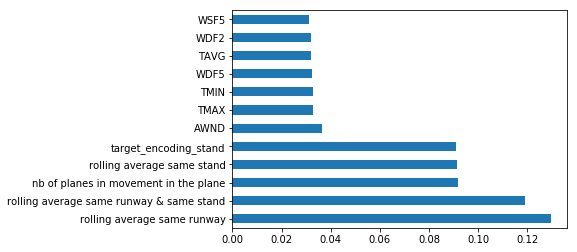

In [17]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

In [19]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [20]:
importances_df = drop_col_feat_imp(rf, X_train, y_train, random_state = 42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykern

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vec

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vec

NameError: name 'imp_df' is not defined

In [22]:
importances_df

NameError: name 'importances_df' is not defined

### CatBoost 

In [8]:
from catboost import CatBoostRegressor
time_start = time.clock()
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.02,
                          depth=12,
                          eval_metric='RMSE',
                          bagging_temperature = 0.2)

column_index = [X_final.columns.get_loc(c) for c in col_dummies if c in X_final]
# Fit model
model.fit(X_train, y_train,cat_features=column_index)
# Get predictions
preds = model.predict(X_test)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

0:	learn: 300.3373652	total: 2.06s	remaining: 6m 50s
1:	learn: 297.5830452	total: 3.56s	remaining: 5m 52s
2:	learn: 294.7312831	total: 4.94s	remaining: 5m 24s
3:	learn: 291.9103818	total: 6.11s	remaining: 4m 59s
4:	learn: 289.1512801	total: 7.23s	remaining: 4m 41s
5:	learn: 286.4539126	total: 8.41s	remaining: 4m 32s
6:	learn: 283.7973294	total: 9.49s	remaining: 4m 21s
7:	learn: 281.3342228	total: 10.6s	remaining: 4m 14s
8:	learn: 278.8071182	total: 11.7s	remaining: 4m 8s
9:	learn: 276.4327261	total: 12.8s	remaining: 4m 3s
10:	learn: 274.2002820	total: 13.9s	remaining: 3m 58s
11:	learn: 271.9856764	total: 15s	remaining: 3m 54s
12:	learn: 269.7121711	total: 16s	remaining: 3m 50s
13:	learn: 267.5616856	total: 17.1s	remaining: 3m 47s
14:	learn: 265.5504586	total: 18.1s	remaining: 3m 43s
15:	learn: 263.4680893	total: 19.2s	remaining: 3m 41s
16:	learn: 261.4846734	total: 20.3s	remaining: 3m 38s
17:	learn: 259.4868378	total: 21.3s	remaining: 3m 35s
18:	learn: 257.5509165	total: 22.4s	remainin

151:	learn: 182.0766636	total: 2m 30s	remaining: 47.5s
152:	learn: 181.7404654	total: 2m 31s	remaining: 46.5s
153:	learn: 181.6685597	total: 2m 31s	remaining: 45.3s
154:	learn: 181.6091286	total: 2m 32s	remaining: 44.2s
155:	learn: 181.5382749	total: 2m 32s	remaining: 43s
156:	learn: 181.4486532	total: 2m 32s	remaining: 41.8s
157:	learn: 181.4106710	total: 2m 32s	remaining: 40.7s
158:	learn: 181.3178792	total: 2m 33s	remaining: 39.6s
159:	learn: 181.2493826	total: 2m 33s	remaining: 38.4s
160:	learn: 181.1815409	total: 2m 33s	remaining: 37.2s
161:	learn: 180.8753862	total: 2m 34s	remaining: 36.4s
162:	learn: 180.5464239	total: 2m 36s	remaining: 35.4s
163:	learn: 180.4803391	total: 2m 36s	remaining: 34.3s
164:	learn: 180.3959760	total: 2m 37s	remaining: 33.3s
165:	learn: 180.1135581	total: 2m 38s	remaining: 32.4s
166:	learn: 180.0259124	total: 2m 40s	remaining: 31.7s
167:	learn: 179.9406730	total: 2m 42s	remaining: 30.9s
168:	learn: 179.8680322	total: 2m 45s	remaining: 30.3s
169:	learn: 

In [9]:
TEST1 = preds/60
TEST2 = [x/60 for x in y_test['target'].tolist()]
print(np.sqrt(sk.metrics.mean_squared_error(TEST1,TEST2)))

2.7309090319735523


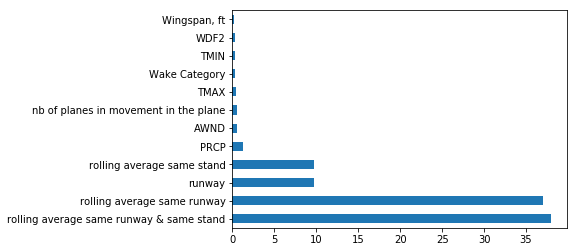

In [11]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')